###  MicroGrad demo

In [33]:
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [34]:
np.random.seed(1337)
random.seed(1337)

In [35]:
# Загрузка данных MNIST
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Преобразование данных в формат float32
x_train = x_train.astype('float64') / 255.0 * 2 - 1
x_test = x_test.astype('float64') / 255.0 * 2 - 1

# Изменение формы данных
x_train = x_train.reshape(x_train.shape[0], 784, 1)
x_test = x_test.reshape(x_test.shape[0], 784, 1)

# One-hot кодирование меток
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=10)

y_train_oh = y_train_oh * 2 - 1
y_test_oh = y_test_oh * 2 - 1

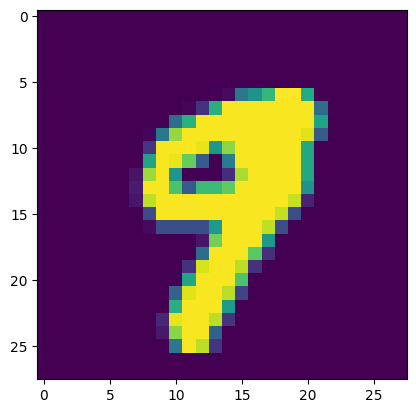

In [36]:
def draw_some(numbers):
    number = numbers[random.randint(0, numbers.shape[0] - 1)]
    plt.imshow(number.reshape([28, 28]))

draw_some(x_train)

In [37]:
positive_class = 0

# Создание массива меток для обучающего набора
y_train_bin = np.ones(y_train.shape) * -1
# Установка меток позитивного класса
y_train_bin[y_train == positive_class] = 1
# Создание массива меток для тестового набора
y_test_bin = np.ones(y_test.shape) * -1
# Установка меток позитивного класса
y_test_bin[y_test == positive_class] = 1

y_test_bin

array([-1., -1., -1., ..., -1., -1., -1.])

In [38]:
from collections import defaultdict

POSITIVE_CLASSES = [0, 1]

def balance(x, y, positive_classes):
    assert -1 not in positive_classes

    p_idx = np.where(np.isin(y, positive_classes))[0]
    n_idx = np.where(~np.isin(y, positive_classes))[0]
    len = min(p_idx.shape[0], n_idx.shape[0])
    p_idx = np.random.permutation(p_idx)[:len]
    n_idx = np.random.permutation(n_idx)[:len]
    idx = np.random.permutation(np.concatenate([p_idx, n_idx]))
    x, y = x[idx], y[idx]

    return x, y

X, Y = balance(x_train, y_train, POSITIVE_CLASSES)

def oh_encode(y, positive_classes):
    gray = np.array([0] * len(positive_classes))
    oh_enc = defaultdict(lambda: gray)
    oh_dec = defaultdict(lambda: None)
    for i, cls in enumerate(positive_classes):
        cls_vec = np.array([-1.0] * len(positive_classes))
        cls_vec[i] = 1.0
        oh_enc[cls] = cls_vec
        oh_dec[tuple(cls_vec)] = cls

    return oh_dec, np.array([oh_enc[cls] for cls in y])

OH_DEC, Y_oh = oh_encode(Y, POSITIVE_CLASSES)
OH_DEC, Y_oh.shape

(defaultdict(<function __main__.oh_encode.<locals>.<lambda>()>,
             {(1.0, -1.0): 0, (-1.0, 1.0): 1}),
 (25330, 2))

In [39]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

# initialize a model
model = MLP(
    784,
    [
        (2, 'tanh')
    ]
)
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [tanh-Neuron(784), tanh-Neuron(784)]]
number of parameters 1570


In [40]:
# loss function
def one_loss(score, ground_truth):
    return sum((s - gt)**2 for s, gt in zip(score, ground_truth))


def loss(X, Y_oh, batch_size):
    ri = np.random.permutation(X.shape[0])[:batch_size]
    X, Y_oh = X[ri], Y_oh[ri]

    input = [list(map(Value, xi)) for xi in X]
    scores = list(map(model, input))

    ground_truths = [list(map(Value, yi)) for yi in Y_oh]
    return sum([one_loss(s, gt) for s, gt in zip(scores, ground_truths)])

total_loss = loss(X, Y_oh, 32)
total_loss

Value(data=100.28727791391235, pgrad=0.0, grad=0.0, lr=1.0)

In [43]:
BATCH_SIZE = 32

# optimization
for k in range(5):

    # forward
    total_loss = loss(X, Y_oh, BATCH_SIZE)
    print(f"step {k} loss {total_loss.data}")

    # backward
    model.zero_grad()
    total_loss.backward()

    # update (sgd)
    # learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.learn(0.5)

total_loss = loss(X, Y_oh, BATCH_SIZE)
model.zero_grad()
total_loss.backward()
print(f"final loss {total_loss.data}")

step 0 loss 81.80061093774539
step 1 loss 102.00000000054443
step 2 loss 85.9998916108747
step 3 loss 101.99176496102625
step 4 loss 95.99997807107647
final loss 91.99999739092145%


In [41]:
parameters = model.parameters()
parameters.sort(key=lambda p: p.lr)
parameters

[Value(data=0.8510708143303627, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.41975996443403285, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.14195796230118485, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.46378965922724125, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.5503992561157605, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.33442134583436256, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.2697478501441004, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.2803092759590373, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.9912909613197056, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.21689730894197434, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.39423983104446525, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.523072625045145, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.7276601480291089, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.2702539844917, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=-0.14902468293253146, pgrad=0.0, grad=0.0, lr=1.0),
 Value(data=0.2703950017502761, pgrad=0.0, grad=0.0, lr=1.0),


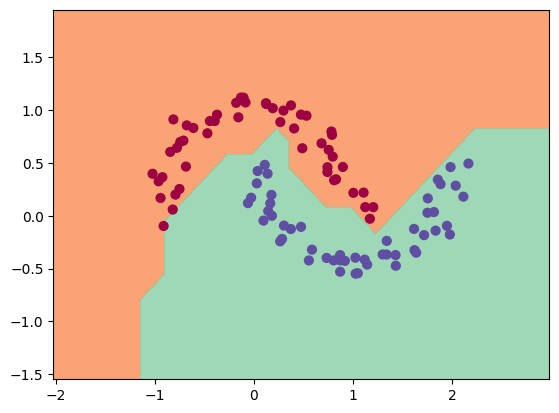

In [30]:
visual()

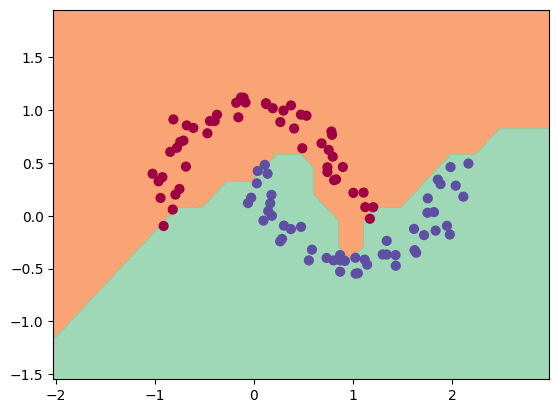

In [26]:
# visualize decision boundary
def visual():
    h = 0.25
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Xmesh = np.c_[xx.ravel(), yy.ravel()]
    inputs = [list(map(Value, xrow)) for xrow in Xmesh]
    scores = list(map(model, inputs))
    Z = np.array([s.data > 0 for s in scores])
    Z = Z.reshape(xx.shape)

    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

visual()

# tanh

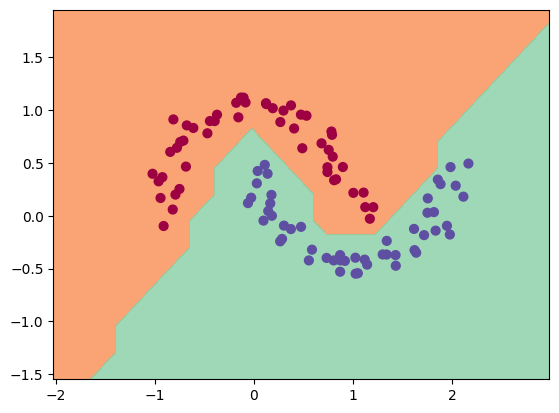

In [8]:
visual()

# relu

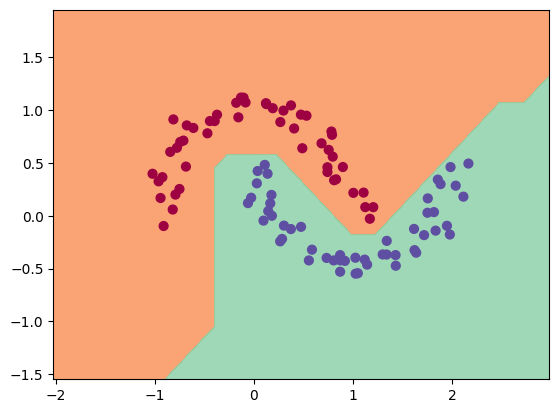

In [12]:
visual()

# tanh with dynamic learning rate <0.5, 1.1>

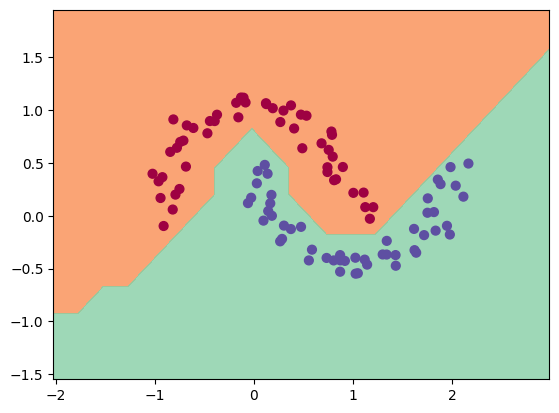

In [8]:
visual()

# relu with dynamic learning rate <0.5, 1.1>

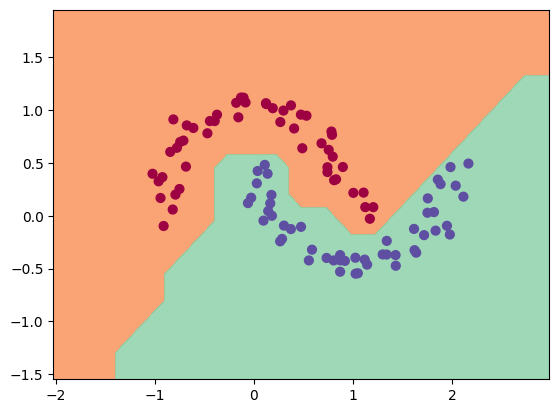

In [22]:
visual()